In [81]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers

print(tf.__version__)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [82]:
dataset_path = "ik_6dof.csv"

In [83]:
column_names = ["translation_x", "translation_y", "translation_z", "theta1", "theta2", "theta3",
                "theta4", "theta5", "theta6"]
raw_dataset = pd.read_csv(dataset_path,
                          names=column_names,
                          na_values="?",
                          sep=",",
                          skipinitialspace=True)

dataset = raw_dataset.copy()
print(dataset.tail())

print(dataset.isna().sum())
dataset = dataset.dropna()

      translation_x  translation_y  translation_z      theta1     theta2  \
9995    -151.157713     171.566117       5.006599  -51.169011  77.344178   
9996    -224.731613      71.274519     124.540729  -20.625085  75.703548   
9997     -51.665504       9.199024     214.219627  -55.629066 -35.285323   
9998     196.070846    -192.481076      24.423088  135.561237  81.604902   
9999     -51.013554     -55.414011     -79.555845   19.400503  66.219363   

          theta3      theta4      theta5      theta6  
9995  -44.702346  115.458836 -159.152054  -81.881913  
9996    4.329717   93.720891  -72.134989  135.640345  
9997  -72.289837   11.369011  -73.103537  -32.909345  
9998  -20.514301  -21.390860   37.445242 -107.086803  
9999 -149.537943 -152.810356   73.506503  144.269638  
translation_x    0
translation_y    0
translation_z    0
theta1           0
theta2           0
theta3           0
theta4           0
theta5           0
theta6           0
dtype: int64


In [84]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
train_labels = train_dataset[["theta1", "theta2", "theta3", "theta4", "theta5", "theta6"]]
test_dataset = dataset.drop(train_dataset.index)
test_labels = test_dataset[["theta1", "theta2", "theta3", "theta4", "theta5", "theta6"]]

In [85]:
model = keras.Sequential([
    layers.Dense(128, activation=tf.nn.tanh, input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation=tf.nn.tanh),
    layers.Dense(len(train_labels.keys()), activation=tf.keras.activations.linear)
])

In [86]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.mean_squared_error,
              metrics=['accuracy', 'mean_squared_error'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 774       
Total params: 18,566
Trainable params: 18,566
Non-trainable params: 0
_________________________________________________________________
None


In [87]:
class PrintDot(keras.callbacks.Callback):
    # noinspection PyMethodOverriding
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [88]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_dataset,
                    train_labels,
                    epochs=1000,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop, PrintDot()])
print('')


................................................................................................


In [89]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
print(history_df.tail())

         acc        loss  mean_squared_error   val_acc    val_loss  \
91  0.909219  140.921226          140.921234  0.885000  266.895354   
92  0.908281  140.667738          140.667725  0.879375  267.405495   
93  0.910156  139.226354          139.226334  0.877500  270.175211   
94  0.908281  139.573631          139.573624  0.879375  267.150642   
95  0.910937  136.209273          136.209274  0.878125  267.297672   

    val_mean_squared_error  epoch  
91              266.895325     91  
92              267.405518     92  
93              270.175262     93  
94              267.150635     94  
95              267.297668     95  


In [90]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label='Val Error')
    plt.semilogy()
    plt.legend()
    plt.show()

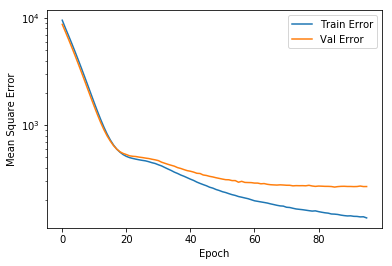

In [91]:
plot_history(history)

In [92]:
loss, accuracy, mse = model.evaluate(test_dataset, test_labels, verbose=0)
print("Test dataset Accuracy: {} Mean Square Error: {}".format(accuracy, mse))

Test dataset Accuracy: 0.8805000185966492 Mean Square Error: 275.60552978515625
